# <center><b><span style="color:#FF5A5F" >AIRBNB</span> x </b> <b><span style="color:#FF5A5F">RENDA SEGURA</span></b></center>

<img src = Airbnb-Logo-Contest.png width="1200">


# Table of Content

##  1) [Introduction](#introduction) 
 
## 2) [Curation of the dataset](#curation)

## 3) [General Overview](#overview)

## 4) [Findings](#conclusion)

# Introduction 

As predicted in the initial proposal, there has been a strong decline in the short-term rental business due to a sharp drop in tourism. A possible solution is to implement the project already initiated by the Lisbon municipality 'Renda Secura' to Aibnb flats. In this way, we could revive a currently stagnant economy by giving a fixed income to the owners of the flats and repopulating the city with its citizens.

In the following notebooke we will alternate parts of storytelling and parts of dataset analysis. The work is structured in several phases. The first part of the work involves the curation of the dataset, a general overview of rents in Lisbon and a statistical survey of the variables. 

## Curation of the dataset <a id="curation"></a>


In [178]:
#import libraries
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import sys
import pylab as p
import folium
from folium.plugins import FastMarkerCluster
from branca.colormap import LinearColormap
import json
import geopandas as gpd
from bokeh.plotting import figure, output_file, show, save
from bokeh.models import LogTicker, ColorBar,GeoJSONDataSource,LinearColorMapper,LogColorMapper,HoverTool, Slider
from bokeh.layouts import row
from bokeh.io import output_notebook, push_notebook
from bokeh.models import FixedTicker
from bokeh.palettes import brewer
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS


Avendo a disposizione un set di dati molto grande, sono state scelte solo le variabili necessarie per l'analisi, poi ho fatto degli aggiustamenti alle colonne che lo richiedevano (per esempio abbiamo arrotondato il numero dei bagni e corretto gli errori di battitura). Ho notato la presenza di outlier di prezzo che confondevano la distribuzione. Di conseguenza, come mostrato nel <b>grafico1</b>, ho deciso di considerare solo i prezzi fino a 500€ per notte, escludendo l'1% delle inserzioni.

Dal momento che il progetto è l'implementazione di Renta Segura alle case di Lisbona utilizzate per affitti a breve termine, ho creato una copia del dataset contenente solo gli annunci della città senza alterare il dataset iniziale.

Tradotto con www.DeepL.com/Translator (versione gratuita)

In [133]:
#import listings
listings = pd.read_csv("listings.csv.gz",compression="gzip")
#columns to use
useful_columns ="id,host_id,host_name,host_since,host_location,host_is_superhost,\
host_listings_count,host_total_listings_count,neighbourhood,\
neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,\
longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,\
bedrooms,beds,amenities,price,minimum_nights,has_availability,availability_30,\
availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,\
review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,\
review_scores_location,review_scores_value,license,calculated_host_listings_count,\
calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,\
calculated_host_listings_count_shared_rooms,reviews_per_month"
useful_columns_list = useful_columns.split(",")
listings = listings[useful_columns_list]
#convert price from string to float
listings.price=listings.price.str.replace(",","").str[1:].astype("float64")
#correct mispelled neighbourhood listings
listings.replace({"Misericrdia":"Misericordia",
                       "So Vicente":"Sao Vicente",
                       "Santo Antnio":"Santo Antonio",
                       "Penha de Frana":"Penha de Franca",
                       "Belm":"Belem",
                       "Alcntara":"Alcantara",
                       "So Domingos de Benfica":"Sao Domingos de Benfica",
                       "Parque das Naes":"Parque das Nacoes"},inplace=True)
#for the sake of semplicity value like 1.5 are 
#rounded to the next integer (2 in the example above)
def get_bath_n(x):
    try:
        if x[0].isnumeric():
            n_bath= round(eval(x.split()[0]))
            return n_bath
        else:
            return n_bath
    except: #np.nan
        return x
listings["bathrooms_text"].replace({"Half-bath":1,"Shared half-bath":1,"Private half-bath":1},inplace=True)
listings["bathrooms_text"]=listings["bathrooms_text"].apply(lambda x: get_bath_n(x))  


In [137]:
#remove price outliers
l=listings.loc[listings.price<=500]

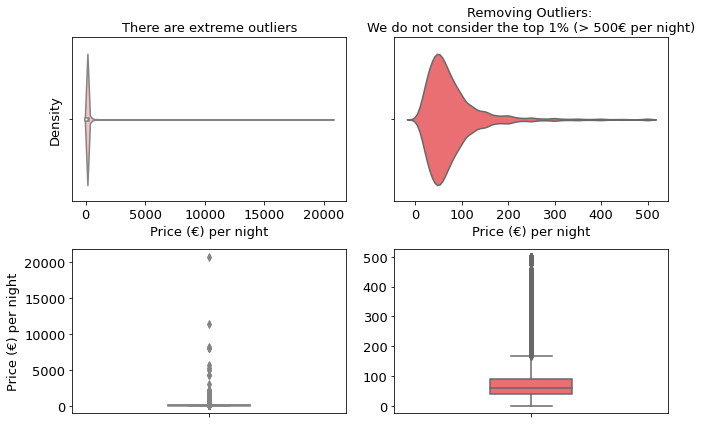

In [141]:
fig,ax = plt.subplots(2,2,figsize=(10,10*.6))
sns.violinplot(ax=ax[0,0],data=listings,x="price", color = "#ffbaba");
sns.violinplot(ax=ax[0,1],data=l,x="price", color = "#FF5A5F", inner = None);
sns.boxplot(ax=ax[1,0], data = listings, y="price", width=0.3, color= "#ffbaba")
sns.boxplot(ax=ax[1,1], data = l, y="price", width=0.3, color = "#FF5A5F")
ax[0,0].set_title("There are extreme outliers", fontsize = 13)
ax[0,0].set_ylabel("Density", fontsize = 13)
ax[0,0].set_xlabel("Price (€) per night", fontsize = 13)
# ax[0,0].set_xticks(fontsize = 13, labelcolor = "#445E8D")

ax[0,1].set_xlabel("Price (€) per night", fontsize = 13)
ax[1,0].set_ylabel("Price (€) per night", fontsize = 13)
ax[1,1].set_ylabel("")

for i in range(2):
    for j in range(2):
        plt.sca(ax[i, j])
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)

ax[0,1].set_title("Removing Outliers: \nWe do not consider the top 1% (> 500€ per night)", fontsize = 13)
plt.tight_layout()
plt.show()

In [145]:
listings_small=pd.read_csv("listings.csv",parse_dates=["last_review"],index_col=0)
#correct name of freguesias
listings_small.replace({"Misericrdia":"Misericordia",
                       "So Vicente":"Sao Vicente",
                       "Santo Antnio":"Santo Antonio",
                       "Penha de Frana":"Penha de Franca",
                       "Belm":"Belem",
                       "Alcntara":"Alcantara",
                       "So Domingos de Benfica":"Sao Domingos de Benfica",
                       "Parque das Naes":"Parque das Nacoes"},inplace=True)
#remove extreme outliers as above
listings_small = listings_small.loc[(listings_small.price<=500)&(listings_small.price>0)]


In [ ]:
## merge listings_small and listings
## create a cleaner dataframe with useful variables only
columns_to_merge=["id","property_type","accommodates","bathrooms_text","bedrooms",
                  "beds","amenities","availability_30","availability_60","availability_90",
                  'number_of_reviews_ltm', 'review_scores_rating','review_scores_accuracy',
                  'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
                  'review_scores_location', 'review_scores_value']
listings_to_merge= listings[columns_to_merge]
listings_small=pd.merge(listings_small, listings_to_merge,on="id",how="left")


In [ ]:
bedroom_labels = ["one_bedroom","two_bedrooms","three_bedrooms","four_bedrooms","4+_bedrooms"]
listings_small["bedrooms_count"]=pd.cut(listings_small.bedrooms,bins=[0,1,2,3,4,25],labels=bedroom_labels,right=True)

In [152]:
#ADD AREA VARIABLE
a= [2.88,5.07,5.34,1.74,2.13,2.99,2.46,10.43,8.03,1.65,2.77,3.69,4.6,6.57,7.12,2.19,8.09,5.44,2.71,3.36,3.01,1.49,4.29,1.99]
freguesia= ['Ajuda',
 'Alcantara',
 'Alvalade',
 'Areeiro',
 'Arroios',
 'Avenidas Novas',
 'Beato',
 'Belem',
 'Benfica',
 'Campo de Ourique',
 'Campolide',
 'Carnide',
 'Estrela',
 'Lumiar',
 'Marvila',
 'Misericordia',
 'Olivais',
 'Parque das Nacoes',
 'Penha de Franca',
 'Santa Clara',
 'Santa Maria Maior',
 'Santo Antonio',
 'Sao Domingos de Benfica',
 'Sao Vicente']
area_freguesia= dict(zip(freguesia, a))
listings_small["area"]=listings_small.neighbourhood.map(area_freguesia)

In [154]:
#WRONG FILECORRECTED (NOT LISTINGS)
lisbon_listings=listings_small.loc[listings_small.neighbourhood_group == "Lisboa"].copy()

## 3 GENERAL OVERVIEW <a id="overview"></a>


This is Joao: 

<img src = joao.jpg width="320">




Joao, his wife Jannina and his son José are expecting a fourth family member: Joaquim. Due to the fact that the current apartment will soon become too small, Joao is looking for a new home. The family wants to stay in Joaos and Joanas hometown: <b> Lisbon </b>. They ask their current landlord Jair for help, because he owns several apartments in the city. However, Jair immediately rejects Joaos and Joanas request: “Ahahaha, no way. I am renting my properties to tourists, they have more money than you.” 

In the recent years, the city of Lisbon welcomed more and more tourists each year. Joao likes to meet people from other countries, but with their high wages from rich countries the tourists occupy more and more housing spaces in the city.  It turned out that they do not only stay in hostels but also rent whole apartments. Most of these short-term rental agreements are closed via a platform called  <b><span style="color:#FF5A5F">Airbnb</span></b>. Let’s see what kind of apartments we can find on Airbnb in Lisbon and where they are:

In [156]:
lats2018 = lisbon_listings['latitude'].tolist()
lons2018 = lisbon_listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[38.70744475993871, -9.136274013769265],
                  zoom_start=13,control_scale=True)
                  #height=500,width=1500)
FastMarkerCluster(data=locations).add_to(map1)
map1

Joao, desperate, decides to turn to his friend Frederico, who works for the city of Lisbon and is following the development of the Renda Segura project. 

Joao: "With the birth of Joaquim, we will definitely need more space. I tried to ask Jair, my current landlord, but I can't afford anything I'm looking for with the prices going around. The only hope I have left is the project that you have started."



Frederico: "I fully understand your problem, my friend. We are looking for new houses to rent to Lisbon citizens like you. In this regard, we are developing research to identify possible dwellings that can be converted from short-term to long-term rentals. To make you understand better, I'll show you some graphs that our analysts have created through the dataset of Airbnb listings in Lisbon: There are mostly small apartments. We can see that bigger apartments are more expensive. No big surprise. Moreover, we identified the most expensive neighbourhoods. Finally, the most central neighbourhoods also have the ihighest density of Airbnbs."



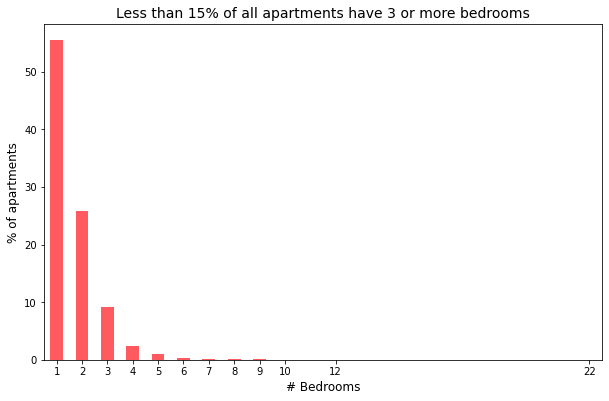

In [158]:
numerical=lisbon_listings.select_dtypes(include=["float64","int64"])
df = numerical[["bedrooms"]].copy()
fig,ax = plt.subplots(1,1,figsize=(10,10*0.618))
hist_bedrooms = df.bedrooms.value_counts(sort=False).sort_index() 
(100*hist_bedrooms/len(df)).plot(kind='bar', color="#FF5A5F") 
# for x in range(len(hist_bedrooms)):
  #   plt.text(x-0.05, (100* hist_bedrooms[x]/len(df)+2), hist_bedrooms[x])
plt.xlabel("# Bedrooms", fontsize = 12)
plt.ylabel("% of apartments", fontsize = 12);
plt.title("Less than 15% of all apartments have 3 or more bedrooms", fontsize = 14)
ticks_pos = plt.xticks()
plt.xticks(ticks=ticks_pos[0], labels = [1,2,3,4,5,6,7,8,9,10,12,22], rotation=None);

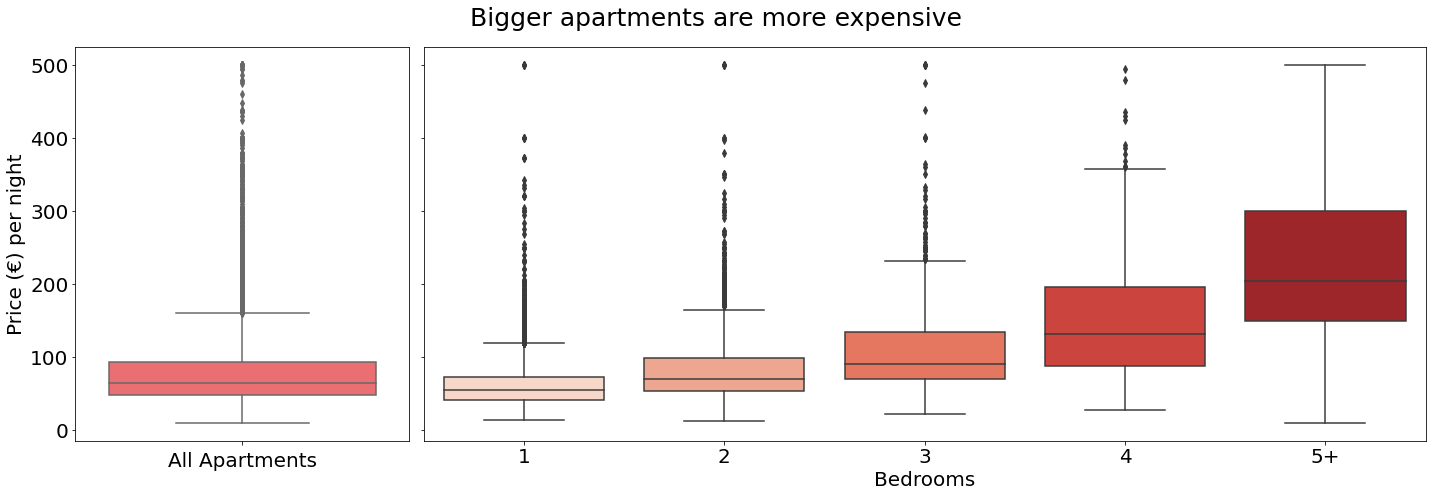

In [159]:
fig, ax = plt.subplots(1,2,figsize=(20,7),gridspec_kw={"width_ratios":[1,3]},sharey=True)
apartments=lisbon_listings.loc[lisbon_listings.room_type=="Entire home/apt"].copy()
sns.boxplot(data=apartments,y="price", color="#FF5A5F", ax=ax[0]);
sns.boxplot(data=apartments,y="price",x="bedrooms_count", palette = "Reds",order=['one_bedroom', 'two_bedrooms','three_bedrooms','four_bedrooms','4+_bedrooms'],ax=ax[1]);
ax[0].set_xlabel("All Apartments", fontsize = 20)
ax[0].set_ylabel("Price (€) per night", fontsize = 20)
ax[1].set_xlabel("Bedrooms", fontsize = 20)
ax[1].set_ylabel("", fontsize = 20)
ticks_pos=plt.xticks()
plt.xticks(ticks=ticks_pos[0], labels = ["1", "2", "3", "4", "5+"])
ax[1] = plt.gca()
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 20)
ax[0].tick_params(axis = 'y', which = 'major', labelsize = 20)

fig.suptitle("Bigger apartments are more expensive",fontsize=25)
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

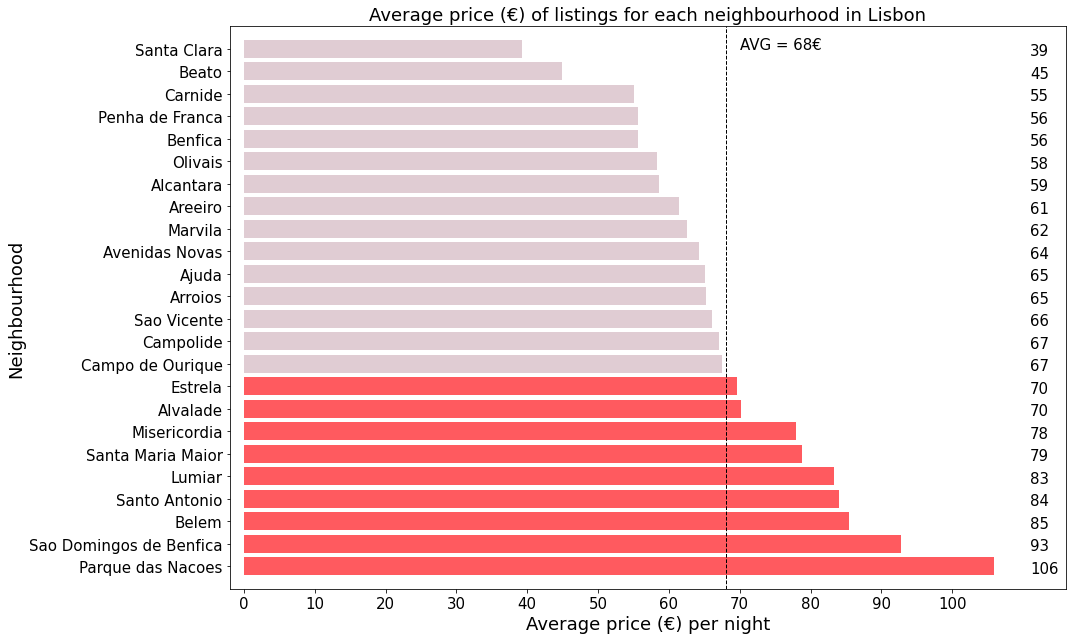

In [160]:
#plt.rcParams['text.color'] = "#445E8D"
price_night = (lisbon_listings
               .groupby("neighbourhood").price
               .mean()
               .reset_index()
               .sort_values("price",ascending=False))

avg= price_night.price.mean()
plt.figure(figsize=(15,9))
#plot neighbourhood in alphabetic order
for i in range(len(price_night)):
    if price_night.price.iloc[i]>avg:
        plt.barh(price_night.neighbourhood.iloc[i],price_night.price.iloc[i],color="#FF5A5F")
    else:
        plt.barh(price_night.neighbourhood.iloc[i],price_night.price.iloc[i],color="#e0ccd3")
    plt.text(x=111,y=i-.3,s=f"{price_night.price.iloc[i]:.0f}",color="k", fontsize = 15)
#plt.barh(price_night.neighbourhood,price_night.price,color="#fcba03");
plt.axvline(x=price_night.price.mean(),linewidth=1,linestyle="dashed",color="k")
#plt.text(x=100,y=10,s="aaaaa")
plt.xlim([-2,116])
plt.ylim([-1,24])
plt.text(x=avg+2,y= len(price_night)-1,s=f"AVG = {avg:.0f}€ ",color="k",fontsize=15)
plt.xticks([i for i in range(0,110,10)], fontsize = 15)
plt.yticks(fontsize = 15)

plt.ylabel("Neighbourhood", fontsize = 18)
plt.xlabel("Average price (€) per night", fontsize = 18)
plt.title("Average price (€) of listings for each neighbourhood in Lisbon", fontsize=18);
plt.tight_layout()
plt.show()

Joao: "So have you identified any neighborhoods to start with yet?"

Frederico: "Our team was able to create a map of Lisbon divided by neighborhoods that shows for each one some information such as: average price, area, and number of listings available. In this way, we have a compact overview of the situation. However, we still need to figure out which apartments would be interesting for our project."

In [161]:
#loading file and correct neighbourhood names
neighborhoods_lisboa = gpd.read_file("destination_data.shp")
neighborhoods_lisboa.rename(columns={"neighbou_1":"city","neighbourh":"neighbourhood"},inplace=True)
neighborhoods_lisboa.replace({"Misericrdia":"Misericordia",
                       "So Vicente":"Sao Vicente",
                       "Santo Antnio":"Santo Antonio",
                       "Penha de Frana":"Penha de Franca",
                       "Belm":"Belem",
                       "Alcntara":"Alcantara",
                       "So Domingos de Benfica":"Sao Domingos de Benfica",
                       "Parque das Naes":"Parque das Nacoes"},inplace=True)
#select only neighbourhood in lisbon
lisboa_geo=neighborhoods_lisboa.loc[neighborhoods_lisboa.city=="Lisboa"].copy()
#statistics from lisbon_listings
lisbon_listings=lisbon_listings.loc[lisbon_listings.room_type=="Entire home/apt"].copy()
lisbon_df=(
  lisbon_listings
 .groupby("neighbourhood")
 .agg({"price":"mean",
       "area":"mean",
       "calculated_host_listings_count":"mean",
       "accommodates":"mean",
       "review_scores_rating":"mean",
       "id":"count"})
 .reset_index()
 .rename(columns={"calculated_host_listings_count":"listings_per_host",
                 "id":"total_listings"})
)
#add density
lisbon_df["listing_density"]= round(lisbon_df["total_listings"]/lisbon_df["area"],2)
#merge with geographic data
lisbon_df=pd.merge(lisboa_geo,lisbon_df,how="left",on="neighbourhood").drop("city",axis=1)

In [162]:
# Creation of .json file
geosource_heat = GeoJSONDataSource(geojson = lisbon_df.to_json())

#creation of color bar
plot_height = 650
plot_width = 180
color_bar_height = plot_height + 11
color_bar_width = 180
#color mapper
color_mapper = LogColorMapper(palette="Viridis256", low=lisbon_df['listing_density'].min(), high = lisbon_df['listing_density'].max()+10)

#Define custom tick labels for color bar.
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

#define color_bar_plot to give name to the colorbar
color_bar_plot = figure(title="Airbnbs per km²", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=0, 
                        outline_line_color=None)

color_bar_plot.add_layout(color_bar, 'right')
color_bar_plot.title.align="center"
color_bar_plot.title.text_font_size = '12pt'

#PLOTTING
palette = color_mapper
#LogColorMapper(palette="Viridis256", low=neighborhoods_stats['price'].min(), high = neighborhoods_stats['price'].max()+10)
                               
hover = HoverTool(tooltips= [
                                ('    NEIGHBOURHOOD    ', '@neighbourhood'),
                                ('Area','@area'),
                                ('Number of apartments', '@total_listings'),
                                ('Average price per night [€]','@price'),   
                                
                                ('Average # of listings per owner','@listings_per_host'),                                
                                ])

p = figure(title = 'The highest density of Airbnbs is in the city center', plot_height = 700 , plot_width = 700, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None


p.patches('xs','ys', source = geosource_heat,fill_color = {'field' :'listing_density', 'transform' : color_mapper}, line_color = 'black', line_width = 0.25, fill_alpha = 1)

# Customize layout
p.background_fill_color = None
p.background_fill_alpha = 0.05

p.border_fill_color = None
p.min_border_left = 20

p.outline_line_width = 7
p.outline_line_alpha = 1
p.outline_line_color = None

p.xaxis.axis_label = "Latitude °"
p.xaxis.axis_line_width = 3
p.xaxis.axis_line_color = "black"

p.yaxis.axis_label = "Longitude °"
p.yaxis.major_label_text_color = "black"
p.yaxis.major_label_orientation = "vertical"

#Colorbar layout
p.add_layout(color_bar, 'below')

#show(p)
layout = row(p, color_bar_plot)

output_notebook()
push_notebook()
show(layout);


Loading BokehJS ...

Joao: "But why are those Airbnbs so expensive?"
    
Frederico: "Well, Airbnbs are not occupied 365 days a year. So, they must charge high priecs per night to offset the missing revenue on empty days. Here I have a graph for you to give you an idea of the capacity usage of Airbnbs"

In [163]:
overnight_stays = np.array([999056,1057221,1443330,1636195,1773863,1750628,1874219,2057193,1821478,1728503,1329017,1167761])
# source (https://travelbi.turismodeportugal.pt/en-us/Pages/PowerBI/overnight-stays.aspx) )
months = [datetime.date(year=2019, month=i, day=1) for i in range(1,13)]
Stays = pd.DataFrame({"overnight stays" : overnight_stays/1000000, "month" : months})

In [164]:
av_stays = overnight_stays.mean()
capacity_usage_at_max = 6/7   # in peak period, average aribnb is booked on 6 days per week
usage_rate = (av_stays/max(overnight_stays)) * capacity_usage_at_max

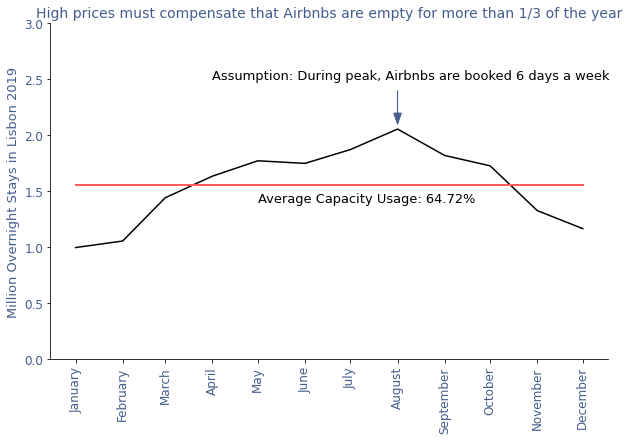

In [165]:
fig,ax = plt.subplots(figsize= (10,10*0.618));
lp = sns.lineplot(data = Stays, 
                     x = "month", 
                     y = "overnight stays",
                     color = "k",
                     ax=ax)
ax.set_ylim(0.0,3)
ax.set_title("High prices must compensate that Airbnbs are empty for more than 1/3 of the year", color="#445E8D", fontsize = 14);
# plt.xlabel("Month", color="#445E8D", fontsize = 14);
plt.xlabel("")
plt.ylabel("Million Overnight Stays in Lisbon 2019", color="#445E8D", fontsize = 13);
plt.xticks(months, ["January","February","March","April","May","June","July","August","September","October","November","December"], rotation=90, color="#445E8D", fontsize = 12);
plt.yticks(color="#445E8D", fontsize = 12)
plt.plot([months[0], months[11]], [av_stays/1000000, av_stays/1000000], color='#FF5A5F', linestyle='-', linewidth=2);
plt.arrow(months[7], 2.4, 0, -0.2, fc="#445E8D", ec="#445E8D",head_width=5, head_length=0.1, color = "#445E8D");
plt.text(months[3],2.5,"Assumption: During peak, Airbnbs are booked 6 days a week", fontdict={"fontsize":13});
plt.text(months[4],1.4,f"Average Capacity Usage: {round(usage_rate*100,2)}%", fontdict={"fontsize":13});
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);

Joao: "Ah of course, that makes sense. But then, if we would let people live in those apartments for a whole year, the prices should go down, no?"

Frederico: "Exactly, my friend. And that's what we're trying to explot with our Renda Segura project. We offer to all owners of Airbnbs a maximum rent of 600€ for a T1, 800€ for a T2, 900€ for a T3 and 1000€ for a T4 and T4+. If we multiply all prices by the some average capacity usage rate, we estimate to sign apartments in the following areas"

## 4) Findings <a id="conclusion"></a>



Under the assumption of an average capacity usage of 64.72%, the Council of Lisbon could implement the strategy exploiting the required 1000 apartments.

In [166]:
def campaign_dataset(df, availability_threshold=10, USAGE_RATE=0.64):
    '''
    -------------------------
    function CAMPAIGN_DATASET
    -------------------------
    input arguments:
    
    - df: DataFrame to analyze
    
    - availability_threshold: int, minimum number of days that 
    listings are not booked in the last 90 days.
    i.e. if availability_threshold=10, it means that listings
    available at least 10 on 90 days will be considered
    
    - 
    ------------------------
    ouput: 
    - proposal_dataset: Dataframe, cointains listings likely to 
    be targeted by Lisbon municipality
    '''
    DAY_IN_MONTH=30
    #first constraint, only entire apartments
    df= df.loc[df["room_type"]=="Entire home/apt"].copy()
    #second constraint, availability
    df = df.loc[df["availability_90"]>availability_threshold].copy()
    #monthly rent
    df["monthly_rent"]= df["price"] * DAY_IN_MONTH
    #adjusted monthly_rent on usage rate
    df["adjusted_rent"] = df["monthly_rent"] * USAGE_RATE
    #apply listings price threshold values from the municipality
    df["threshold"]=df.bedrooms.apply(lambda x: threshold(x))
    #slice dataframe if adjusted monthly price is lower than the municipality threshold
    proposal_dataset= df.loc[df["threshold"]>=df["adjusted_rent"]].copy()
    
    return proposal_dataset   
    
def threshold(x):
    thres_dict={
        1:600,
        2:800,
        3:900,        
    }
    t=0
    if x in thres_dict.keys():
        t=thres_dict[x]
        return t
    else:
        t=1000
        return t 

In [167]:
final_df=campaign_dataset(lisbon_listings, availability_threshold=10)

In [168]:
lats_selected = final_df['latitude'].tolist()
lons_selected = final_df['longitude'].tolist()
locations = list(zip(lats_selected, lons_selected))

map2 = folium.Map(location=[38.736946,-9.142685],
                  zoom_start=11.5,control_scale=True,)


folium.CircleMarker(
    location=[38.736946, -9.142685],
    radius=200,
    popup='Lisboa',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(map2)


FastMarkerCluster(data=locations).add_to(map2);
map2

In [169]:
def campaign_dataset_bokeh(df, lisbon_df=lisbon_df, availability_threshold=10, USAGE_RATE=0.64):
    '''
    -------------------------
    function CAMPAIGN_DATASET
    -------------------------
    input arguments:
    
    - df: DataFrame to analyze
    
    - availability_threshold: int, minimum number of days that 
    listings are not booked in the last 90 days.
    i.e. if availability_threshold=10, it means that listings
    available at least 10 on 90 days will be considered
    
    - 
    ------------------------
    ouput: 
    - proposal_dataset: Dataframe, cointains listings likely to 
    be targeted by Lisbon municipality
    '''
    DAY_IN_MONTH=30
    #first constraint, only entire apartments
    df= df.loc[df["room_type"]=="Entire home/apt"].copy()
    #second constraint, availability
    df = df.loc[df["availability_90"]>availability_threshold].copy()
    #monthly rent
    df["monthly_rent"]= df["price"] * DAY_IN_MONTH
    #adjusted monthly_rent on usage rate
    df["adjusted_rent"] = df["monthly_rent"] * USAGE_RATE
    #apply listings price threshold values from the municipality
    df["threshold"]=df.bedrooms.apply(lambda x: threshold(x))
    #slice dataframe if adjusted monthly price is lower than the municipality threshold
    proposal_dataset= df.loc[df["threshold"]>=df["adjusted_rent"]].copy()
    
    campaign=proposal_dataset.groupby("neighbourhood").agg({"id":"count","price":"mean"}).reset_index().rename(columns={"id":"campaign_counts","price":"campaign_price"})
    lisbon_df=pd.merge(lisbon_df,campaign,how="left",on="neighbourhood")
    lisbon_df["turnover_campaign"]= round(lisbon_df["campaign_counts"]/lisbon_df["total_listings"],2)*100
    lisbon_df["campaign_counts"].fillna(0,inplace=True)
    lisbon_df["campaign_counts"]=lisbon_df["campaign_counts"].astype(int)

    return lisbon_df
    
def threshold(x):
    thres_dict={
        1:600,
        2:800,
        3:900,        
    }
    t=0
    if x in thres_dict.keys():
        t=thres_dict[x]
        return t
    else:
        t=1000
        return t 

In [170]:
lisbon_df=campaign_dataset_bokeh(lisbon_listings)

In [171]:
# Creation of .json file
geosource_heat = GeoJSONDataSource(geojson = lisbon_df.to_json())

#creation of color bar
plot_height = 650
plot_width = 180
color_bar_height = plot_height + 11
color_bar_width = 180
#color mapper
palette= brewer["Reds"][8]
palette=palette[::-1]
color_mapper = LogColorMapper(palette=palette, low=lisbon_df['turnover_campaign'].min(), high = lisbon_df['turnover_campaign'].max()+5)

#Define custom tick labels for color bar.
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

#define color_bar_plot to give name to the colorbar
color_bar_plot = figure(title="TURNOVER RATE", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=0, 
                        outline_line_color=None)

color_bar_plot.add_layout(color_bar, 'right')
color_bar_plot.title.align="center"
color_bar_plot.title.text_font_size = '12pt'

#PLOTTING
palette = color_mapper
                               
hover = HoverTool(tooltips= [
                                ('    NEIGHBOURHOOD    ', '@neighbourhood'),
                                ('Area','@area'),
                                ('Number of apartments', '@total_listings'),
                                ('Number of apartments renta segura','@campaign_count'),
                                ('Average price [€]','@price'),
                                ('Average price[€] for renta segura','@campaign_price')                                
                                ])

p = figure(title = 'Most turnover in the central neighbourhood', plot_height = 700 , plot_width = 700, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None


p.patches('xs','ys', source = geosource_heat,fill_color = {'field' :'turnover_campaign', 'transform' : color_mapper}, line_color = 'black', line_width = 0.25, fill_alpha = 1)

# Customize layout
p.background_fill_color = None
p.background_fill_alpha = 0.05

p.border_fill_color = None
p.min_border_left = 20

p.outline_line_width = 7
p.outline_line_alpha = 1
p.outline_line_color = None

p.xaxis.axis_label = "Latitude °"
p.xaxis.axis_line_width = 3
p.xaxis.axis_line_color = "black"

p.yaxis.axis_label = "Longitude °"
p.yaxis.major_label_text_color = "black"
p.yaxis.major_label_orientation = "vertical"

#Colorbar layout
p.add_layout(color_bar, 'below')

#show(p)
layout = row(p, color_bar_plot)

output_notebook()
push_notebook()
show(layout);

Loading BokehJS ...

In [172]:
campaign=final_df.groupby("neighbourhood").agg({"id":"count","price":"mean"}).reset_index().rename(columns={"id":"campaign_counts","price":"campaign_price"})
campaign.head()


,neighbourhood,campaign_counts,campaign_price
0,Ajuda,10,31.200000
1,Alcantara,20,36.000000
2,Alvalade,7,38.714286
3,Areeiro,8,39.625000
4,Arroios,93,32.569892


In [173]:
def campaign_dataset_bokeh(df, lisbon_df=lisbon_df, availability_threshold=10, USAGE_RATE=0.64):
    '''
    -------------------------
    function CAMPAIGN_DATASET
    -------------------------
    input arguments:
    
    - df: DataFrame to analyze
    
    - availability_threshold: int, minimum number of days that 
    listings are not booked in the last 90 days.
    i.e. if availability_threshold=10, it means that listings
    available at least 10 on 90 days will be considered
    
    - 
    ------------------------
    ouput: 
    - proposal_dataset: Dataframe, cointains listings likely to 
    be targeted by Lisbon municipality
    '''
    DAY_IN_MONTH=30
    #first constraint, only entire apartments
    df= df.loc[df["room_type"]=="Entire home/apt"].copy()
    #second constraint, availability
    df = df.loc[df["availability_90"]>availability_threshold].copy()
    #monthly rent
    df["monthly_rent"]= df["price"] * DAY_IN_MONTH
    #adjusted monthly_rent on usage rate
    df["adjusted_rent"] = df["monthly_rent"] * USAGE_RATE
    #apply listings price threshold values from the municipality
    df["threshold"]=df.bedrooms.apply(lambda x: threshold(x))
    #slice dataframe if adjusted monthly price is lower than the municipality threshold
    proposal_dataset= df.loc[df["threshold"]>=df["adjusted_rent"]].copy()
    
    campaign=proposal_dataset.groupby("neighbourhood").agg({"id":"count","price":"mean"}).reset_index().rename(columns={"id":"campaign_count","price":"campaign_price"})
    lisbon_df=pd.merge(lisbon_df,campaign,how="left",on="neighbourhood")
    lisbon_df["turnover_campaign"]= round(lisbon_df["campaign_count"]/lisbon_df["total_listings"],2)*100
    lisbon_df["campaign_count"].fillna(0,inplace=True)
    lisbon_df["campaign_count"]=lisbon_df["campaign_count"].astype(int)

    return lisbon_df
    
def threshold(x):
    thres_dict={
        1:600,
        2:800,
        3:900,        
    }
    t=0
    if x in thres_dict.keys():
        t=thres_dict[x]
        return t
    else:
        t=1000
        return t 

In [174]:
lisbon_df=campaign_dataset_bokeh(lisbon_listings)

In [175]:
l1 = list(listings_small["id"]) 
#l2 = list(selected_listings["id"])
l2 = list(final_df["id"])
results = np.in1d(l1, l2)
listings_small["attracted"] = results

Joao: "Nice! Thats is space for a lot of people, and in nice areas! But are those only the bad and cheap Airbnbs, or are those proper apartments?"

Frederico: "Well, as you can see in the following figure, the rating of the apartments we could sign are lower compared to all other Airbnbs, but they still of good ratings overall!"

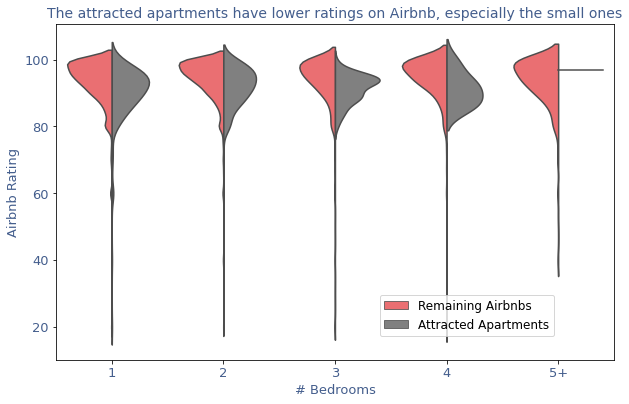

In [176]:
fig, ax = plt.subplots(1,1, figsize=(10,10*0.618))

sns.violinplot(x="bedrooms_count" ,y="review_scores_rating", hue="attracted", data=listings_small, inner=None, palette = {True:"grey", False:"#FF5A5F"}, split=True, ax=ax);

plt.title("The attracted apartments have lower ratings on Airbnb, especially the small ones", color="#445E8D", fontsize = 14)
plt.xlabel("# Bedrooms", color="#445E8D", fontsize = 13)
plt.ylabel("Airbnb Rating", color="#445E8D", fontsize = 13);

handles = ax.get_legend_handles_labels()[0]

ax.legend(loc=(0.58,0.07), labels = ["Remaining Airbnbs", "Attracted Apartments"], handles = handles, fontsize=12)
# L = plt.legend()
# L.get_texts()[0].set_text('Remaining Airbnbs')
# L.get_texts()[1].set_text('Attracted Appartments')
# plt.legend(loc=(0.64,0.07))

ticks_pos = plt.xticks()
plt.xticks(ticks=ticks_pos[0], labels = ["1", "2", "3", "4", "5+"], color="#445E8D", fontsize = 13);
plt.yticks(color="#445E8D", fontsize = 13);

Joao: "But the average capacity rate you showed me before is just an estimation. What happens if it changes? Especially now, in a world wide pandemic? Also when the pandemic is over, it will take time for toursim to recover."

Frederico: "We have two more secanrios for this case. Depending on how much tourism will recover, we may attract an extra of 49%!"

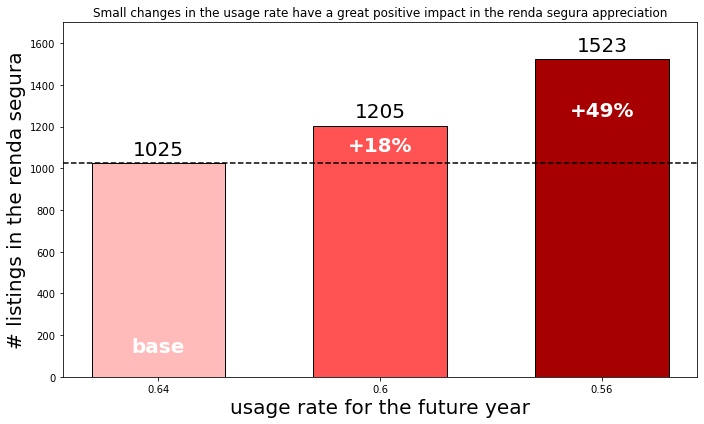

In [177]:
possible_rates=[0.64,0.6,0.56]
col=["#ffbaba","#ff5252","#a70000"]
counts_renda=[]

plt.figure(figsize=(10,6))
for n,rate in enumerate(possible_rates):
    d=campaign_dataset_bokeh(lisbon_listings,USAGE_RATE=rate)
    tot=d.campaign_count.sum()
    counts_renda.append(tot)
    plt.bar(n,tot,width=.6,color=col[n],edgecolor="k")
    plt.text(n,tot+20,f"{tot}",ha="center",va="bottom",fontsize=20)

t1=((counts_renda[1]-counts_renda[0])/counts_renda[0])*100
t2=((counts_renda[2]-counts_renda[0])/counts_renda[0])*100
plt.axhline(y=counts_renda[0],linestyle="dashed",color="k")
plt.text(0,100,"base",ha="center",va="bottom",color="w",fontsize=20,weight="heavy")
plt.text(1,counts_renda[0]+40,f"+{t1:.0f}%",ha="center",va="bottom",color="w",fontsize=20,weight="heavy")   
plt.text(2,counts_renda[0]+205,f"+{t2:.0f}%",ha="center",va="bottom",color="w",fontsize=20,weight="heavy")
plt.title("Small changes in the usage rate have a great positive impact in the renda segura appreciation")
plt.xticks(ticks=[0,1,2],labels=possible_rates)
plt.ylim([0,1700])
plt.xlabel("usage rate for the future year",fontsize=20)
plt.ylabel("# listings in the renda segura",fontsize=20)
plt.tight_layout()
plt.show()

Joao: "Wow! I think you guys are doing a great job with the Renda Segura program. I will definetly apply for one of your apartments. It seems like chances are high that you actually have one for me and my family. Thank you so much Frederico!"